In [4]:
import numpy as np
import random

# Network Modelling

We'll explore 2 networks to see how it can model structure in observations related to suspense and the blackjack game:
- A linear network
- A recurrent network

We'll start by defining a data generation process to use as our training data. For this, we need arrays of 5 card draws as the input, with the corresponding suspense 

In [380]:
params = {
    "maxCard" : 9,
    "minCard" : -9,
    "upperBound" : 10,
    "totalDraws" : 5
}

def getCardSequence(params: dict) -> np.ndarray:

    return np.asarray([random.randint(params["minCard"], params["maxCard"]) for _ in range(params["totalDraws"])])

# Cumulative score, card pair presented -> suspense

def getSuspenseSequence(cardSequence: np.array, suspenseModel, params: dict) -> np.ndarray:
    """
    Remember, card sequences need to be 5 draws, where before each draw the player is shown 2 cards.
    Without this, we're modelling suspense in a different way than the data we're gathering, as effectively 
    the expected future belief update would involve forming expectations based on the entire deck, not on the 2 
    cards they see before they spin the wheel.

    We can implement a couple of suspense models here to try different learning functions
    For example, we could have:
        - A random model
        - Ely suspense (L1 norm)
        - Distance to upper bound
        - Distance to bound modified by number of cards left in sequence
    """

    # Get the cumulative sum of draws
    cs = np.cumsum(cardSequence, axis=0, dtype=np.float32)[0:, 0]
    # Get the card pairs at each hand
    pairs = np.asarray(np.split(cardSequence, params["totalDraws"]), dtype=np.float32).squeeze()
    # Store everything in output dict
    results = {
        "cs": cs,
        "pairs" : pairs,
        "suspense" : []
    }
    
    if suspenseModel == None:
        raise ValueError("No suspense model provided.")
    
    if suspenseModel == "random":
        # Randomly generate 5 values
        results["suspense"] = np.array([random.randint(1, 5) for _ in range(params["totalDraws"])], dtype=np.float32)
    
    elif suspenseModel == "ely":
        # Ely suspense is based on an internal probability model - do we want to give this to the network or let it try and learn this?
        # Surely that would be part of the point?
        pass
    elif suspenseModel == "toUpperBound":
        # Whichever of the 2 cards is closest to the upper bound, use that difference for suspense
        results["suspense"] = 5*np.exp(-np.min((abs(pairs - params["upperBound"])), axis=1)/params["upperBound"])
    else:
        raise ValueError(f"Model {suspenseModel} not recognised.")
    
    return results

def makeDataset():

    return

In [384]:
allX = []
allY = []

for i in range(1):
    cardSeq1 = getCardSequence(params)
    cardSeq2 = getCardSequence(params)
    # Format into pairs of cards
    cardSeq = np.concatenate((
        cardSeq1.reshape(-1, 1), cardSeq2.reshape(-1, 1)
    ), axis=1)

    results = getSuspenseSequence(cardSeq, "toUpperBound", params)

    # results
    regResults = {}

    # Normalise data to between -1 and 1
    regResults['cs'] = results['cs'] / np.array([35], dtype=np.float32) # 35 being the largest score, w/ a constraint that we can't repeat cards (i.e. 9+8+7+6+5)
    regResults['pairs'] = results['pairs'] / np.array([params['maxCard']], dtype=np.float32) # Divide by 9 to normalise

    # Format into inputs
    allX.append(np.concatenate((regResults['cs'], regResults['pairs'].flatten())))
    allY.append(results['suspense'])

allX = np.asarray(allX)
allY = np.asarray(allY)


In [385]:
results

{'cs': array([ -7., -15., -13., -22., -26.], dtype=float32),
 'pairs': array([[-7.,  0.],
        [-8.,  8.],
        [ 2., -4.],
        [-9.,  0.],
        [-4., -9.]], dtype=float32),
 'suspense': array([1.8393971, 4.0936537, 2.2466447, 1.8393971, 1.2329848],
       dtype=float32)}

In [377]:
results['pairs'][0][0]

-7.0

In [240]:
allX, allY

(array([[ 0.08571429, -0.11428571,  0.        , -0.02857143, -0.2857143 ,
          0.33333334, -0.5555556 , -0.7777778 ,  0.11111111,  0.44444445,
         -0.5555556 , -0.11111111, -0.6666667 , -1.        ,  0.22222222],
        [-0.25714287, -0.2       , -0.2857143 , -0.17142858, -0.11428571,
         -1.        , -0.22222222,  0.22222222, -0.44444445, -0.33333334,
          0.8888889 ,  0.44444445, -0.7777778 ,  0.22222222,  0.5555556 ],
        [-0.2       , -0.14285715, -0.25714287, -0.34285715, -0.42857143,
         -0.7777778 ,  0.33333334,  0.22222222,  1.        , -0.44444445,
          0.11111111, -0.33333334,  0.5555556 , -0.33333334,  0.33333334],
        [ 0.        ,  0.17142858, -0.05714286,  0.11428571,  0.17142858,
          0.        , -0.8888889 ,  0.6666667 ,  0.        , -0.8888889 ,
         -0.11111111,  0.6666667 , -0.5555556 ,  0.22222222, -0.5555556 ],
        [ 0.11428571,  0.02857143, -0.2       ,  0.02857143, -0.14285715,
          0.44444445,  0.8888889 ,

With our inputs and suspenses, we'll build out the network

In [305]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sklearn.model_selection as skm

print("Cuda available?", torch.cuda.is_available())

Cuda available? True


In [306]:
X_train, X_test, y_train, y_test = skm.train_test_split(allX, allY, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [307]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 15]),
 torch.Size([800, 5]),
 torch.Size([200, 15]),
 torch.Size([200, 5]))

In [308]:
# Define an MLP
class TorchMLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()

        self.layers = torch.nn.Sequential(
            # input layer
            torch.nn.Linear(num_features, 15),
            torch.nn.Tanh(),

            # Hidden layers
            torch.nn.Linear(15, 15),
            torch.nn.Tanh(),

            # Output layer
            torch.nn.Linear(15, 5)
        )

    def forward(self, x):
        return self.layers(x)
    
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.labels.shape[0]

In [309]:
# Get dataloader objects

train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_ds, batch_size=24, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=24, shuffle=False)

In [355]:
def computeTotalLoss(model, dataloader, device=None):
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    loss = 0.0
    examples = 0.0

    for ix, (features, labels) in enumerate(dataloader):

        features, labels = features.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(features)
            batch_loss = F.mse_loss(logits, labels, reduce="sum")

        loss += batch_loss.item()
        examples += logits.shape[0]

    return loss / examples

def computeAccuracy(model, dataLoader, device=None):
    # This won't work without some ammendment as it's expecting categorical data or oh-vectors
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    correct = 0.0
    total_examples = 0

    for ix, (features, labels) in enumerate(dataLoader):
        features, labels = features.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(features)

            acc = F.mse_loss(logits, labels, reduction="mean")/(16)
    
    # print(f"Correctly answered {correct} out of {total_examples} = {100*correct/total_examples}%")

    return 1 - acc

In [356]:
model = TorchMLP(num_features=15)
model.to("cuda")
optimiser = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 50
train_losses = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model = model.train()
    for batch_ix, (features, labels) in enumerate(train_loader):
        features = features.to("cuda")
        labels = labels.to("cuda")
        logits = model(features)
        loss = F.mse_loss(logits, labels, reduction="mean")

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if batch_ix == 0:
            train_loss = computeTotalLoss(model, train_loader, device="cuda")
            val_loss = computeTotalLoss(model, test_loader, device="cuda")
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_acc = computeAccuracy(model, test_loader, device="cuda")
            val_accs.append(val_acc)

            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f"  |   Train Batch loss: {train_loss:.4f}"
                f"  |   Val Batch loss: {val_loss:.4f}"
                f"  |   Val acc: {100*val_acc:.4f}%"
            )

c:\Users\agrog\Documents\UCL\Project\Code\expecting-suspense\.venv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001/050  |   Train Batch loss: 0.4748  |   Val Batch loss: 0.5041  |   Val acc: 34.3104%
Epoch: 002/050  |   Train Batch loss: 0.2871  |   Val Batch loss: 0.3049  |   Val acc: 61.1992%
Epoch: 003/050  |   Train Batch loss: 0.1300  |   Val Batch loss: 0.1398  |   Val acc: 83.1722%
Epoch: 004/050  |   Train Batch loss: 0.0857  |   Val Batch loss: 0.0940  |   Val acc: 88.9498%
Epoch: 005/050  |   Train Batch loss: 0.0808  |   Val Batch loss: 0.0892  |   Val acc: 89.3475%
Epoch: 006/050  |   Train Batch loss: 0.0804  |   Val Batch loss: 0.0888  |   Val acc: 89.2848%
Epoch: 007/050  |   Train Batch loss: 0.0803  |   Val Batch loss: 0.0887  |   Val acc: 89.2472%
Epoch: 008/050  |   Train Batch loss: 0.0803  |   Val Batch loss: 0.0887  |   Val acc: 89.2322%
Epoch: 009/050  |   Train Batch loss: 0.0802  |   Val Batch loss: 0.0886  |   Val acc: 89.2259%
Epoch: 010/050  |   Train Batch loss: 0.0802  |   Val Batch loss: 0.0886  |   Val acc: 89.2227%
Epoch: 011/050  |   Train Batch loss: 0.

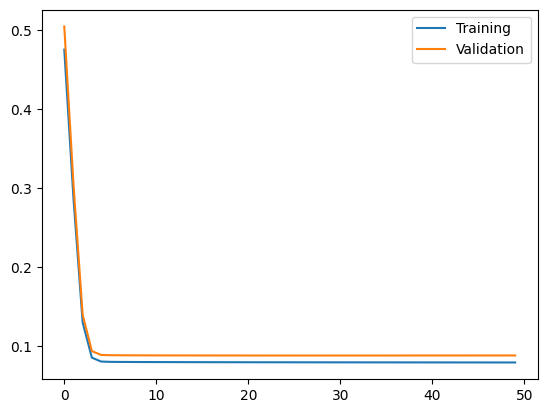

In [357]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

In [266]:
for ix, (features, labels) in enumerate(test_loader):
    print(features[0], labels[0])
    break

tensor([-0.0286,  0.0000,  0.2571,  0.5143,  0.4000, -0.1111,  0.7778,  0.1111,
        -0.2222,  1.0000,  0.5556,  1.0000,  0.6667, -0.4444,  0.5556]) tensor([3.7041, 2.0328, 4.5242, 4.5242, 3.0327])


In [271]:
((np.array([1, 2, 3, 4, 5]) - np.array([1.2, 2.1, 3.1, 4.4, 5.1]))**2).mean()

0.04600000000000005

In [315]:
F.mse_loss(torch.tensor([1, 2, 3, 4, 5]), torch.tensor([1.2, 2.1, 3.1, 4.4, 5.1]), reduction="sum")

tensor(0.2300)

In [372]:
def demo(model, device="cuda"):
    params = {
        "maxCard" : 9,
        "minCard" : -9,
        "upperBound" : 10,
        "totalDraws" : 5
    }

    # generate 2 sequences:

    cardSeq1 = getCardSequence(params)
    cardSeq2 = getCardSequence(params)
    # Format into pairs of cards
    cardSeq = np.concatenate((
        cardSeq1.reshape(-1, 1), cardSeq2.reshape(-1, 1)
    ), axis=1)

    results = getSuspenseSequence(cardSeq, "toUpperBound", params)

    # encode for network
    regResults = {}

    # Normalise data to between -1 and 1
    regResults['cs'] = results['cs'] / np.array([35], dtype=np.float32) # 35 being the largest score, w/ a constraint that we can't repeat cards (i.e. 9+8+7+6+5)
    regResults['pairs'] = results['pairs'] / np.array([params['maxCard']], dtype=np.float32) # Divide by 9 to normalise

    allX = []
    allY = []

    # Format into inputs
    allX.append(np.concatenate((regResults['cs'], regResults['pairs'].flatten())))
    allY.append(results['suspense'])

    X = torch.tensor(allX, dtype=torch.float32)
    Y = torch.tensor(allY, dtype=torch.float32)

    inf_ds = MyDataset(X, Y)
    inf_loader = DataLoader(dataset=inf_ds, batch_size=1, shuffle=False)

    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    for ix, (features, labels) in enumerate(inf_loader):
        features, labels = features.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(features)

            acc = 1 - F.mse_loss(logits, labels, reduction="mean")/(16)

    # print(results)
    # print(logits.squeeze())

    # Produce summary:
    print("--- Inference Results ---\n")

    for cards, cs, sus, modSus in zip(results['pairs'], results['cs'], results['suspense'], logits.squeeze()):
        print(f" Drew: {cards[0]}  |  Alt:  {cards[1]}  |  Sum:  {cs}  |  Suspense:  {sus:.3f}  |  Model Suspense:  {modSus:.3f}  |  Accuracy: {100*acc:.3f}%")





In [373]:
demo(model)

--- Inference Results ---

 Drew: -9.0  |  Alt:  -7.0  |  Sum:  -9.0  |  Suspense:  0.913  |  Model Suspense:  2.906  |  Accuracy: 92.522%
 Drew: -8.0  |  Alt:  6.0  |  Sum:  -17.0  |  Suspense:  3.352  |  Model Suspense:  2.934  |  Accuracy: 92.522%
 Drew: 8.0  |  Alt:  4.0  |  Sum:  -9.0  |  Suspense:  4.094  |  Model Suspense:  2.835  |  Accuracy: 92.522%
 Drew: 6.0  |  Alt:  -3.0  |  Sum:  -3.0  |  Suspense:  3.352  |  Model Suspense:  2.872  |  Accuracy: 92.522%
 Drew: 2.0  |  Alt:  4.0  |  Sum:  -1.0  |  Suspense:  2.744  |  Model Suspense:  2.888  |  Accuracy: 92.522%


In [350]:
F.mse_loss(torch.tensor([[5, 5, 5, 5, 5]], dtype=torch.float32), torch.tensor([[1, 1, 1, 1, 1]], dtype=torch.float32), reduction="sum")

tensor(80.)